In [1]:
%run tools.py

### Fst/PBS analysis on RNA-Seq data - Freebayes ploidy X

Here, I want to do a gene-based FST and gene-based PBS analysis, between treatment groups. Comparisons have been stored in the file data/DE.comparison.list.

In [2]:
comparisons = pd.read_csv("../../resources/DE.comparison.list", header=None)
comparisons.columns = ['contrast']
comparisons = comparisons.contrast.str.split("_", expand=True)
comparisons.columns = ['sus', 'res']

comparisons = [list(row) for i,row in comparisons.iterrows()]
print(f"The pairwise comparisons for Fst are {comparisons}")

The pairwise comparisons for Fst are [['ContAngola', 'FenAngola'], ['NewOrleans', 'ContAngola'], ['Rockefeller', 'ContAngola']]


In [3]:
samples = pd.read_csv("../../config/samples.tsv", sep="\t")
gffpath = "../../resources/reference/VectorBase-48_AaegyptiLVP_AGWG.gff"
pbs = True
ploidy = 10 # args.ploidy

pbscomps = [['FenAngola', 'ContAngola', 'NewOrleans']] #args.pbsgroups 

numbers = {
    'samples':1,
    'variants/CHROM': 1,
    'variants/POS': 1,
    'variants/ID': 1,
    'variants/REF': 1,
    'variants/ALT': 'A',
    'variants/QUAL': 1,
    'variants/DP': 1,
    'variants/AN': 1,
    'variants/AC': 'A',
    'variants/AF': 'A',
    'variants/MQ': 1,
    'variants/ANN': 1,
    'calldata/DP': 1,
    'calldata/GT': ploidy,
    'calldata/GQ': 1,
    'calldata/HQ': 2,
    'calldata/AD': 'R',
    'calldata/MQ0': 1,
    'calldata/MQ': 1,
}

chroms = ["1","2","3"]

features = allel.gff3_to_dataframe(gffpath,
                       attributes=["ID", "description"])
gff = features[features.type == 'gene']

#open 
gene_names = pd.read_csv("../../resources/gene_names.tsv", sep="\t")
gene_names.columns = ['GeneID' if x=='Gene_stable_ID' else x for x in gene_names.columns]

#### Load VCFs and extract arrays

Lets load our VCF and annotation data, and store what we need in easy to reach variables.

In [4]:
for comp1, comp2 in comparisons:
    print(comp1 + "_" +comp2)

ContAngola_FenAngola
NewOrleans_ContAngola
Rockefeller_ContAngola


In [15]:
fstpbsbychrom=dict()
tajdbychrom=dict()
gdivbychrom = dict()

for chrom in chroms:
    
    #path to vcf
    path = f"../../results/variants/annot.variants.{chrom}.vcf.gz"
    #function to read in vcfs and associated SNP data
    vcf, geno, acsubpops, pos, depth, snpeff, subpops, pops =  readAndFilterVcf(path=path, 
                                                               chrom=chrom, 
                                                               qualflt=30, 
                                                               plot=False)
    #subset gff to appropriate chrom
    genes = gff[gff.seqid == f"AaegL5_{chrom}"].sort_values('start').reset_index(drop=True)

    ### Average Fst, pbs, tajima d for each gene 
    fst_per_comp = dict()
    fst_per_gene = dict()
    pbs_per_gene = dict()
    pbs_per_comp = dict()
    tajd_per_pop = dict()
    tajd_per_gene = dict()
    gdiv_per_pop = dict()
    gdiv_per_gene = dict()
    se_dict = dict()
    pos_dict = dict()
    n_dict = dict()

    #loop through each gene and 
    for i, gene in genes.iterrows():
        ID = gene.ID
        #locate_ranges() to get a boolean, needed as locate_range() will throw errors if no snps found in gene
        gene_bool = pos.locate_ranges([gene['start']], [gene['end']], strict=False)
        nsnps = gene_bool.sum()

        #if there are less than 3 snps in this gene then skip to next in loop
        if nsnps < 3:
            continue

        #store number of snps per gene
        n_dict[ID] = nsnps
        #store midpoint positions of gene
        pos_dict[ID] = (gene['start'] + gene['end'])/2

        #fst per gene between each comparison
        for comp1,comp2 in comparisons:
            name = comp1 + "_" + comp2
            ac1 = acsubpops[comp1].compress(gene_bool, axis=0)
            ac2 = acsubpops[comp2].compress(gene_bool, axis=0)

            fst_per_comp[name], se_dict[name],_,_= allel.average_hudson_fst(ac1, ac2, blen=1)   

        #tajimas d and sequence diversity per gene for each subpop(i.e treatment)
        for subpop in subpops:
            ac = acsubpops[subpop].compress(gene_bool)
            genepos = pos[gene_bool]
            tajd_per_pop[subpop] = allel.tajima_d(ac=ac, pos=genepos)
            gdiv_per_pop[subpop] = allel.sequence_diversity(ac=ac, pos=genepos)

        #pbs for each gene for each pbc comparison as defined in config.yaml
        if pbs is True:
            for pbscomp in pbscomps:
                name = pbscomp[0] + "_" + pbscomp[1] + "_" + pbscomp[2]
                pbs_per_comp[name],se,_,_ = meanPBS(acsubpops[pbscomp[0]].compress(gene_bool, axis=0),
                                          acsubpops[pbscomp[1]].compress(gene_bool, axis=0), 
                                          acsubpops[pbscomp[2]].compress(gene_bool, axis=0), 
                                                     window_size=1,
                                                    normalise=True)
        #store inner dict in outer dicts
        fst_per_gene[ID] = dict(fst_per_comp)
        if pbs is True : pbs_per_gene[ID] = dict(pbs_per_comp)
        tajd_per_gene[ID] = dict(tajd_per_pop)
        gdiv_per_gene[ID] = dict(gdiv_per_pop)
    
    #reverse the dicts so the comparisons/subpops are on the outer dict
    fst_per_gene = flip_dict(fst_per_gene)
    if pbs is True : pbs_per_gene = flip_dict(pbs_per_gene)
    tajd_per_gene = flip_dict(tajd_per_gene)
    gdiv_per_gene = flip_dict(gdiv_per_gene)

        
    for comp1,comp2 in comparisons:
        name = comp1 + "_" + comp2 
        a = np.array(list(fst_per_gene[name].values()))
        print(f"Overall Fst for chromosome {chrom} between {name} is {np.nanmean(a)}")

    #make dataframe of number of snps per gene (that pass quality and missingness filters)
    ndf = pd.DataFrame.from_dict(n_dict, orient='index').reset_index(drop=False)
    ndf.columns = ['GeneID', 'nSNPs']

    #make dataframe of midpoints of each gene
    posdf = pd.DataFrame.from_dict(pos_dict, orient='index').reset_index(drop=False)
    posdf.columns = ['GeneID', 'Gene_midpoint']

    #make dataframe of fst for each comparison
    fst_dfs = dict()
    for comp1,comp2 in comparisons:
        name = comp1 + "_" + comp2
        fst_df = pd.DataFrame.from_dict(fst_per_gene[name], orient='index').reset_index(drop=False)
        fst_df.columns = ['GeneID', (name + '_Fst')]
        fst_dfs[name] = fst_df
    
    my_reduce = partial(pd.merge, on='GeneID', how='outer')
    fst_allcomparisons = reduce(my_reduce, fst_dfs.values())
    fst_allcomparisons['chrom'] = chrom

    tajd_dfs = dict()
    gdiv_dfs = dict()
    #store sequence diversityt and tajimas d for each gene and each subpop 
    for subpop in subpops:
        tajd_df = pd.DataFrame.from_dict(tajd_per_gene[subpop], orient='index').reset_index(drop=False)
        tajd_df.columns = ['GeneID', (subpop+"_Tajima_d")]
        tajd_dfs[subpop] = tajd_df
        gdiv_df = pd.DataFrame.from_dict(gdiv_per_gene[subpop], orient='index').reset_index(drop=False)
        gdiv_df.columns = ['GeneID', (subpop+"_SeqDiv")]
        gdiv_dfs[subpop] = gdiv_df

    #combine tajimas d and sequence diversity for each sample
    tajdall = reduce(my_reduce, tajd_dfs.values())  
    gdivall = reduce(my_reduce, gdiv_dfs.values())
    tajdall['chrom'] = chrom
    gdivall['chrom'] = chrom

    #pbs store as dataframes
    pbs_dfs = dict()
    if pbs is True:
        for pbscomp in pbscomps:
            name = pbscomp[0] + "_" + pbscomp[1] + "_" + pbscomp[2]
            pbs_df = pd.DataFrame.from_dict(pbs_per_gene[name], orient='index').reset_index(drop=False)
            pbs_df.columns = ['GeneID', (name+"PBS")]
            pbs_dfs[name] = pbs_df

        pbs_allcomparisons = reduce(my_reduce, pbs_dfs.values())  
    
    dfs = [fst_allcomparisons,pbs_allcomparisons, gene_names, ndf, posdf]
    tajdbychrom[chrom] = reduce(lambda  left,right: pd.merge(left,right,on=['GeneID'],
                                                how='inner'), [tajdall, gene_names, ndf,posdf])
    gdivbychrom[chrom] = reduce(lambda  left,right: pd.merge(left,right,on=['GeneID'],
                                                how='inner'), [gdivall, gene_names, ndf, posdf])
    fstpbsbychrom[chrom] = reduce(lambda  left,right: pd.merge(left,right,on=['GeneID'],
                                                how='inner'), dfs)


-------------- Reading VCF for chromosome 1 --------------
{'FenAngola': [0, 7, 10], 'NewOrleans': [1, 8, 11], 'ContAngola': [2, 4, 5], 'Rockefeller': [3, 6, 9]} 

------- Filtering VCF at QUAL=30 and missingness proportion of 0.6 -------
After QUAL filter, 568812 SNPs retained out of 743586 for chromosome 1
After missingness filter, 313624 SNPs retained out of 568812 for chromosome 1


/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:756: RuntimeWarning: invalid value encountered in true_divide
  vb = num_bsum / den_bsum
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:760: RuntimeWarning: invalid value encountered in double_scalars
  statistic=lambda n, d: np.sum(n) / np.sum(d))
/home/sanj/apps/anaconda3/envs/pysanj/lib/python3.7/site-packages/allel/stats/fst.py:749: RuntimeWarning: invalid value encountered in double_scalars
  fst = np.nansum(num) / np.nansum(den)
/home/sanj/projects/IR/rna-seq-ir/workflow/scripts/tools.py:107: RuntimeWarning: Mean of empty slice
  meanpbs = np.nanmean(pbs)


Overall Fst for chromosome 1 between ContAngola_FenAngola is 0.15462287801472213
Overall Fst for chromosome 1 between NewOrleans_ContAngola is 0.37992901712882865
Overall Fst for chromosome 1 between Rockefeller_ContAngola is 0.3411035713350055

-------------- Reading VCF for chromosome 2 --------------
{'FenAngola': [0, 7, 10], 'NewOrleans': [1, 8, 11], 'ContAngola': [2, 4, 5], 'Rockefeller': [3, 6, 9]} 

------- Filtering VCF at QUAL=30 and missingness proportion of 0.6 -------
After QUAL filter, 894659 SNPs retained out of 1165366 for chromosome 2
After missingness filter, 502185 SNPs retained out of 894659 for chromosome 2
Overall Fst for chromosome 2 between ContAngola_FenAngola is 0.1388413139162078
Overall Fst for chromosome 2 between NewOrleans_ContAngola is 0.36559415617546026
Overall Fst for chromosome 2 between Rockefeller_ContAngola is 0.3004931488935985

-------------- Reading VCF for chromosome 3 --------------
{'FenAngola': [0, 7, 10], 'NewOrleans': [1, 8, 11], 'ContAngo

### Write to CSV

In [16]:
fstpbsall = pd.concat(fstpbsbychrom.values(), ignore_index=True)
tajdall = pd.concat(tajdbychrom.values(), ignore_index=True)
gdivall = pd.concat(gdivbychrom.values(), ignore_index=True)

fstpbs_merged.to_csv(f"../../results/variants/snptesting/Fst_PBS_per_comparison.tsv", index=False, sep="\t")
tajd_all_samples.to_csv(f"../../results/variants/snptesting/tajimas_d.tsv", index=False, sep="\t")
gdiv_all_samples.to_csv(f"../../results/variants/snptesting/sequence_div.tsv", index=False, sep="\t")

### how does fst correlate with the number of snps

In [345]:
n = np.array(list(n_dict.values()))
fst = np.array(list(fst_dict.values()))
midpos = np.array(list(pos_dict.values()))

Is there any correlation between nsnps per gene and fst? 

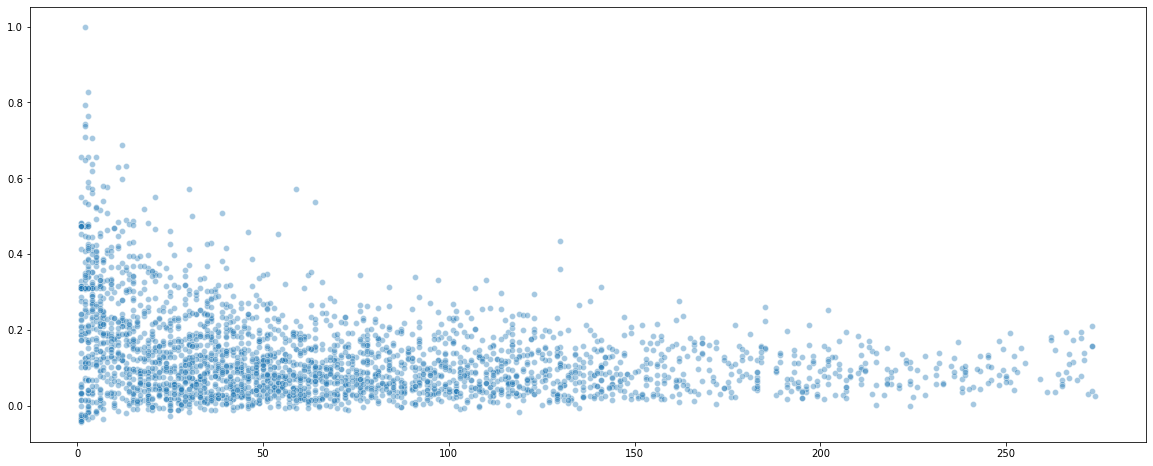

In [347]:
fst2 =fst[~is_outlier(n)]
n2 = n[~is_outlier(n)]

plt.figure(figsize=[20,8])
sns.scatterplot(n2,fst2, alpha=0.4)

In [350]:
geneswithsnpsidx = np.array(list(n_dict.keys())) #get indices of genes with snps
n_bool = n > 3 #get bool of genes that had more than 3 snps

topgenes_idx = largest_indices(fst[n_bool], 200)

fstgenes = genes.take(geneswithsnpsidx)
fstgenes = genes[_bool]
fstgenes = fstgenes.take(topgenes_idx[0])
fstgenes.shape

aegypti_names = pd.read_csv("../../resources/gene_names.tsv", sep="\t")
aegypti_names.columns = ['ID' if x=='Gene_stable_ID' else x for x in aegypti_names.columns]

fstresults = pd.merge(g3, aegypti_names).sort_values('start')

For each gene, we want to get a boolean of the snps in that gene, compress the allele counts to that gene, then do average hudson fst for each gene.

## Calculating Fst in moving windows

In [38]:
size=100
step=50
fst = allel.moving_hudson_fst(sus_ac, res_ac, size=size, 
                                      step=step)
newpos = allel.moving_midpoint(pos, 
                               size=size, 
                               step=step)

In [39]:
na = np.isnan(fst)
fstval = fst[~na]
posval = newpos[~na]

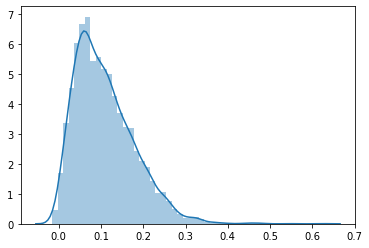

In [50]:
sns.distplot(fstval)

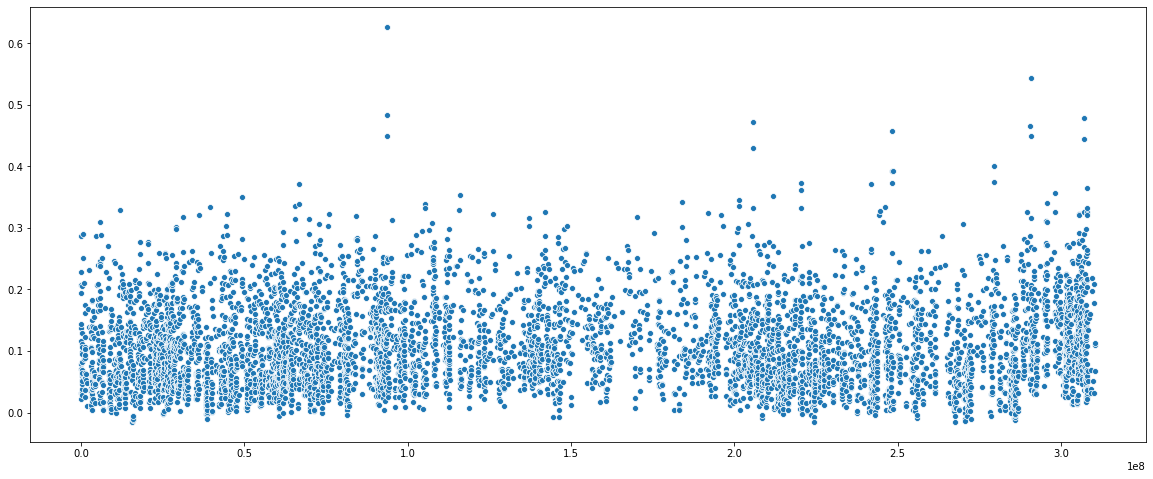

In [40]:
plt.figure(figsize=(20, 8))
sns.scatterplot(posval, fstval)

In [49]:
nsnps = len(fstval)*0.001
largfst = largest_indices(fstval, int(nsnps))
allel.SortedIndex(np.sort(newpos[largfst]))

<SortedIndex shape=(6,) dtype=float64>
[93580820.0, 93582174.0, 205662419.0, 290663610.5, 290689309.5, 307133790.5]